## Create a simple assistant using an LLM and Pydantic

Given a product name, it should return:

```python
Product --> {
  product_name: str,
  product_details: str,
  tentative_price: int | float  # in USD
}

Use ChatPromptTemplate

In [1]:
import os
import json
from IPython.display import Image, display
from typing import Union, List
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser


In [2]:
# Set the Groq API Key
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Langsmith tracing and monitoring
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT") 

In [3]:
# Define Pydantic output schema
class ProductInfo(BaseModel):
    product_name: str = Field(..., description="The name of the product")
    product_details: str = Field(..., description="A brief description of the product")
    tentative_price: Union[float, int] = Field(..., description="The estimated price in USD")


In [4]:
# Create an output parser based on Pydantic
output_parser = PydanticOutputParser(pydantic_object=ProductInfo)

output_parser


PydanticOutputParser(pydantic_object=<class '__main__.ProductInfo'>)

In [5]:
# Define the system message with a placeholder for the format schema
system_messages = """
You are a tech expert. Your task is to extract structured product information based on the following schema:

{format_instruction}

Requirements:
1. Take the product name provided by the user.
2. Return detailed specs like RAM, ROM, Processor, Camera, Battery, Screen Size, and any other relevant information.
3. Return a tentative price in USD (must be numeric only).
"""


# Create the chat prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", system_messages),
    ("human", "{product_name}")
]).partial(format_instruction=output_parser.get_format_instructions())

In [6]:
# Load the Groq model
model = ChatGroq(
    model="gemma2-9b-it",  
    temperature=0 # use a low temerature to get somewhat consistent resoonses 
)
model

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x1400f7b30>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x130578140>, model_name='gemma2-9b-it', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
# Chain: prompt | model | parser
chain = prompt | model | output_parser
chain

ChatPromptTemplate(input_variables=['product_name'], input_types={}, partial_variables={'format_instruction': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"product_name": {"description": "The name of the product", "title": "Product Name", "type": "string"}, "product_details": {"description": "A brief description of the product", "title": "Product Details", "type": "string"}, "tentative_price": {"anyOf": [{"type": "number"}, {"type": "integer"}], "description": "The estimated price in USD", "title": "Tentative Price"}}, "required": ["product_name", "product_details

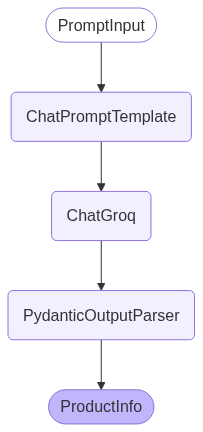

In [ ]:
# display the chain
display(Image(chain.get_graph().draw_mermaid_png()))

In [9]:
# Function to get product info
def get_product_info(product_name: str) -> ProductInfo:
    return chain.invoke({"product_name": product_name})

In [10]:
def format_product_info(info: ProductInfo) -> str:
    # Convert to dict
    data = info.model_dump()
    
    # Format the price as a USD string
    data["tentative_price"] = f"${data['tentative_price']:,.2f} USD"
    
    # Pretty-print JSON string
    json_str = json.dumps(data, indent=2)
    return json_str



In [11]:
# Test on a single product
product = "Sony WH-1000XM5"
try:
    info = get_product_info(product)
    out = format_product_info(info)
    print(out)
except Exception as e:
    print(f"Error: {e}")


{
  "product_name": "Sony WH-1000XM5",
  "product_details": "Industry-leading noise cancellation, exceptional sound quality, and comfortable fit make these headphones a top choice for audiophiles and everyday listeners.",
  "tentative_price": "$399.99 USD"
}


In [12]:
def run_batch(products: List[str]):
    all_infos = []
    for p in products:
        try:
            info = chain.invoke({"product_name": p})
            formatted = format_product_info(info)
            #print(formatted)
            all_infos.append(formatted)
        except Exception as e:
            print(f"Error processing '{p}': {e}")
    return all_infos 


In [13]:
# Test on a list of test products
test_products = [
    "Sony WH-1000XM5",
    "Apple Watch Series 9",
    "Kindle Paperwhite",
    "Nintendo Switch OLED",
    "Samsung Galaxy Tab S9"]

results = run_batch(test_products)

for product_json in results:
    print(product_json)

{
  "product_name": "Sony WH-1000XM5",
  "product_details": "Industry-leading noise cancellation, exceptional sound quality, and comfortable fit make these headphones a top choice for audiophiles and everyday listeners.",
  "tentative_price": "$399.99 USD"
}
{
  "product_name": "Apple Watch Series 9",
  "product_details": "The Apple Watch Series 9 is a smartwatch with advanced health and fitness tracking features, a bright always-on display, and cellular connectivity options.",
  "tentative_price": "$399.00 USD"
}
{
  "product_name": "Kindle Paperwhite",
  "product_details": "A lightweight, waterproof e-reader with a sharp 6.8\u201d display, adjustable warm light, and weeks of battery life.",
  "tentative_price": "$139.99 USD"
}
{
  "product_name": "Nintendo Switch OLED",
  "product_details": "The Nintendo Switch OLED model features a vibrant 7-inch OLED screen, enhanced audio, a wider adjustable stand, and a dock with a wired LAN port.",
  "tentative_price": "$349.99 USD"
}
{
  "produ